# 單純只使用simsiam 
## embedding判斷人臉

### import package

In [1]:
import os
import numpy as np
import torch
import glob
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch import nn
from torchvision import datasets, transforms
from os import listdir
from os import walk
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization
import PIL.Image as Image
from matplotlib import pyplot as plt
import simsiam.loader
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm 
from IPython.display import clear_output
import math
import torch.nn.functional as F

### check gpu

In [2]:
DATA_PATH_TRAIN = '../../dataset/face_labeled_data/train'
DATA_PATH_VAL = '../../dataset/face_labeled_data/val'
DATA_PATH_TEST = '../../dataset/face_labeled_data/test'
DATA_PATH_NEVER = '../../dataset/face_labeled_data/never_seen'

# MODEL_PATH = "./model_facenet_simsiam/checkpoint_0100.pth.tar"
# MODEL_PATH = "./model_featureExtraction_triplet/checkpoint_0100.pth.tar"
MODEL_PATH = "./model_V2_1024_fix_simOne/checkpoint_0100.pth.tar"
BATCH_SIZE = 32
WORKERS = 8

print('torch version:' + torch.__version__)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Available GPUs: ', end='')
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i), end=' ')
else:
    device = torch.device('cpu')
    print('CUDA is not available.')

torch version:1.8.0
Available GPUs: GeForce RTX 2080 Ti GeForce GTX 1080 Ti 

### Data augmentation

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          
def get_aug_trnsform(s=1.0):
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.1)

    transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([simsiam.loader.GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
    
    return transform

def ge_eval_trnsform(s=1.0):
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.1)

    transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    
    return transform

trans_aug = get_aug_trnsform(0.5)
trans_eval = get_aug_trnsform(0.5)

#### Define dataset, and dataloader

In [4]:
class FaceImages(Dataset):
    
    def __init__(self, img_dir, transform, specific = '**'):
        self.img_dir = img_dir
        self.img_path_list = glob.glob(os.path.join(img_dir, specific + '/*.jpg'))
        self.transform = transform
        
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, idx):
        img_path = self.img_path_list[idx]
        img = FaceImages.read_image(img_path)
        target = img_path.split('/')[5]
        return self.transform(img), self.transform(img), target
    
    @staticmethod
    def read_image(img_path):
        #return cv2.imread(img_path)
        return Image.open(img_path, mode='r').convert('RGB')

In [5]:
# dataset_train = FaceImages(DATA_PATH_TRAIN, transform=trans_aug)
# dataset_val = FaceImages(DATA_PATH_VAL, transform=trans_eval)
# dataset_test = FaceImages(DATA_PATH_TEST, transform=trans_eval)

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset_train = datasets.ImageFolder(DATA_PATH_TRAIN, transform=trans)
dataset_val = datasets.ImageFolder(DATA_PATH_VAL, transform=trans)
dataset_test = datasets.ImageFolder(DATA_PATH_TEST, transform=trans)
dataset_never = datasets.ImageFolder(DATA_PATH_NEVER, transform=trans)


train_loader = DataLoader(
    dataset_train,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    dataset_val,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_loader = DataLoader(
    dataset_test,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=False
)

never_loader = DataLoader(
    dataset_never,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=False
)


### load model

In [6]:
# make embedding to length=1
class L2_norm(nn.Module):
    def __init__(self):
        super(L2_norm, self).__init__()

    def forward(self, x):
        return F.normalize(x, p=2, dim=-1)

In [8]:
def loadEvalModel(model_path):
    backbone = InceptionResnetV1()
#     projector = nn.Sequential(
#     nn.Linear(512, 2048), nn.BatchNorm1d(2048), nn.ReLU(),
#     nn.Linear(2048, 2048), nn.BatchNorm1d(2048), nn.ReLU(),
#     nn.Linear(2048, 512), L2_norm()
#     ) 
    projector = nn.Sequential(
        nn.Linear(512, 1024), nn.BatchNorm1d(1024), nn.ReLU(),
        nn.Linear(1024, 1024), nn.BatchNorm1d(1024), nn.ReLU(),
        nn.Linear(1024, 512), L2_norm()
    ) 
    model = nn.Sequential(
    backbone,
    projector
    )
#     model = InceptionResnetV1()
    model.load_state_dict(torch.load(model_path)['state_dict'])
#     model = torch.load(MODEL_PATH)
    model.to(device)
    model.eval()
    return model
val_model = loadEvalModel(MODEL_PATH)

### collapse check(simularity matrix)

In [9]:
def collapseCheck(model, loader):
    x, _ = next(iter(loader))
    h = model(x.to(device))
    h_norm = h / h.norm(dim=1)[:, None]
    res = torch.mm(h_norm, h_norm.transpose(0,1))
    print(res.cpu().detach().numpy())
    
collapseCheck(val_model, val_loader)

[[1.0000002  0.15576303 0.7640194  ... 0.7310251  0.78960437 0.60508615]
 [0.15576303 1.0000001  0.35645607 ... 0.26613665 0.26564243 0.1840412 ]
 [0.7640194  0.35645607 1.0000001  ... 0.6046189  0.671275   0.5030476 ]
 ...
 [0.7310251  0.26613665 0.6046189  ... 1.         0.97744435 0.9274306 ]
 [0.78960437 0.26564243 0.671275   ... 0.97744435 1.0000001  0.9112089 ]
 [0.60508615 0.1840412  0.5030476  ... 0.9274306  0.9112089  0.9999999 ]]


### validation

In [10]:
def validation(data_loader, model):
    y_pre_list = []
    y_list = []    
    for i_batch, image_batch in tqdm(enumerate(data_loader)):
        x = image_batch[0].to(device)
        y = image_batch[1]
        y_pre = model(x)
        y_pre = y_pre.cpu().detach().numpy()
        for j, data in enumerate(y_pre):
            y_pre_list.append(data)
            y_list.append(int(y[j]))
    return y_pre_list, y_list

In [12]:
size=dataset_val.__len__()
print('val data size = ', size)

y_pre, y = validation(test_loader, val_model)

val data size =  2116


73it [00:04, 18.00it/s]


### 計算兩embeddings之距離
distance_metric = 0 歐幾里得距離  (Euclidean distance)  
distance_metric = 1 餘弦相似性 (Cosine similarity)

In [13]:
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidean distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),0)
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=0)
        norm = np.linalg.norm(embeddings1, axis=0) * np.linalg.norm(embeddings2, axis=0)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric 
    return dist

### 計算Cluste  離散度
1.根據target分群  
2.計算每一群中心點  
3.每一群的所有點對中心點計算歐式距離  
4.上步驟所有距離取平均  
5.所有群的平均距離再取平均  


In [14]:
def calculateClusterDistance(y_pre, target):
    dist = []
    y_new = np.array(y_pre)
    for index, target_str in enumerate(np.unique(target)):
        cluster_dist = 0
        data = y_new[[x for x, y in list(enumerate(target))if y == target_str]]
        meanPoint = np.mean(data, axis=0)
        for embedding in data:
            cluster_dist += distance(embedding, meanPoint)
        dist.append(cluster_dist / len(data))
    return np.mean(dist)

In [15]:
def calculateClusterVAL(y_pre, target, d = 1):
    ta = []
    y_new = np.array(y_pre)
    for index, target_str in tqdm(enumerate(np.unique(target))):
        data = y_new[[x for x, y in list(enumerate(target))if y == target_str]]
        count = 0
        ta_count = 0
        if len(data) <= 1:
            continue
        for i in range(len(data) - 1):
            for j in range(i + 1, len(data)):
                count+=1
                if distance(data[i], data[j]) <= d:
                    ta_count+=1
        ta.append(ta_count / count)
    return np.mean(ta)
def calculateClusterFAR(y_pre, target, d = 1):
    fa = []
    y_new = np.array(y_pre)
    for index, target_str in tqdm(enumerate(np.unique(target))):
        data = y_new[[x for x, y in list(enumerate(target))if y == target_str]]
        other_data = y_new[[x for x, y in list(enumerate(target))if y != target_str]]
        count = 0
        fa_count = 0
        if len(data) <= 1:
            continue
        for i in range(len(data)):
            for j in range(len(other_data)):
                count+=1
                if distance(data[i], other_data[j]) <= d:
                    fa_count+=1
        fa.append(fa_count / count)
    return np.mean(fa)

def calculateClusterVAL_FAR(y_pre, target, val_d, far_d):
    y_new = np.array(y_pre)
    ta_count = 0
    ta_count_true = 0
    fa_count = 0
    fa_count_true = 0
    for i in range(len(y_new) - 1):
        for j in range(i, len(y_new)):
            dist = distance(y_new[i], y_new[j])
            if target[i] == target[j]:
                ta_count += 1
                if dist <= val_d:
                    ta_count_true += 1
            else:
                fa_count += 1
                if dist <= far_d:
                    fa_count_true +=1
    return ta_count_true / ta_count, fa_count_true / fa_count

### Acc公式
對每一筆data找k個最近的data 看有多少是相同的class

### TA 公式
<img src="img/TA.png" width="50%">  

### FA 公式
<img src="img/FA.png" width="50%">  

### VAL FAR
<img src="img/VAL_FAR.png" width="50%">  


### gpu 算距離

In [16]:
def pdist(v):
    dist = torch.norm(v[:, None] - v, dim=2, p=2)
    return dist

def makemask(targets):
    n = targets.shape[0]
    # find the hardest positive and negative
    mask_pos = targets.expand(n, n).eq(targets.expand(n, n).t())
    mask_neg = ~mask_pos
    mask_pos[torch.eye(n).byte().to(device)] = 0
    return mask_pos, mask_neg

def calculateClusterVAL_FAR_GPU(y_pre, target, val_d = 1., far_d = 1.):
    dist = pdist(torch.Tensor(y_pre).cpu())
    mask_pos, mask_neg = makemask(torch.Tensor(target).cpu())
    
#     print(dist)
    dist[dist == 0] = float('nan')
    
    pos = dist * mask_pos.float()
#     print('pos pre', pos)
    pos[pos == 0] = float('nan')

    neg = dist * mask_neg.float()
#     print('neg pre', neg)
    neg[neg == 0] = float('nan')
#     print('mask_pos ', mask_pos)
#     print('mask_neg ', mask_neg)
#     print('pos ', pos)
#     print('neg ', neg)
    ta = torch.sum(pos <= far_d)
    fa = torch.sum(neg <= far_d)

    psame = torch.sum(mask_pos == True)
    pdiff = torch.sum(mask_neg == True)
    
    val = ta / psame
    far = fa / pdiff
    return val.detach().numpy(), far.detach().numpy()

def calculateClusterACC_GPU(y_pre, target, k = 2):
    dist = pdist(torch.Tensor(y_pre).cpu())
    dist[dist == 0] = float('nan')
    mask_pos, mask_neg = makemask(torch.Tensor(target).cpu())
#     print(dist)
    values, indices = torch.topk(dist, k, largest = False)
    
#     print(indices)
#     print(torch.gather(mask_pos, 1, indices))
    acc_count = torch.sum(torch.gather(mask_pos, 1, indices) == True, 1) / k
    acc = acc_count / k
    return acc.detach().numpy().mean()

def calculateClusterDistClose_GPU(y_pre, target):
    dist = pdist(torch.Tensor(y_pre).cpu())
    mask_pos, mask_neg = makemask(torch.Tensor(target).cpu())    
#     print(dist)
    dist[dist == 0] = float('nan')
    pos = dist * mask_pos.float()
#     print('pos pre', pos)
    pos[pos == 0] = float('nan')
    neg = dist * mask_neg.float()
#     print('neg pre', neg)
    neg[neg == 0] = float('nan')
#     print('mask_pos ', mask_pos)
#     print('mask_neg ', mask_neg)
#     print('pos ', pos)
#     print('neg ', neg)
    sameD_val = torch.nansum(pos)
    diffD_val = torch.nansum(neg)

    psame = torch.sum(mask_pos == True)
    pdiff = torch.sum(mask_neg == True)
    
#     print('sameD_val ', sameD_val)
#     print('diffD_val ', diffD_val)
#     print('psame ', psame)
#     print('pdiff ', pdiff)
    sameD = sameD_val / psame
    diffD = diffD_val / pdiff
    return sameD.detach().numpy(), diffD.detach().numpy()

# test_y_pre = [[0, 1], [0, 5], [0, 2], [0, 6]]
# test_y = [1, 2, 1, 2]

# calculateClusterVAL_FAR_GPU(test_y_pre, test_y)
# calculateClusterDistClose_GPU(test_y_pre, test_y)
#calculateClusterACC_GPU(test_y_pre, test_y)

In [17]:
calculateClusterDistClose_GPU(y_pre, y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378098133/work/aten/src/ATen/native/IndexingUtils.h:30.)
  # Remove the CWD from sys.path while we load stuff.


(array(0.45010266, dtype=float32), array(1.4152678, dtype=float32))

In [18]:
def cal(y_pre, y, kMax = 10):
    valList = []
    farList = []
    accList = []
    accK = []
#     ds = [2, 1.5, 1, 0.5, 10**-1, 10**-2, 10**-3, 10**-4, 10**-5, 10**-6]
    for i in tqdm(range(21)):
        power = i - 1
        val, far = calculateClusterVAL_FAR_GPU(y_pre, y, i / 10, i / 10)
        valList.append(val)
        farList.append(far)
    for k in tqdm(range(1, kMax + 1)):
        acc = calculateClusterACC_GPU(y_pre, y, k)
        accList.append(acc)
        accK.append(k)    
    return valList, farList, accList, accK
valList, farList, accList, accK = cal(y_pre, y, 10)

  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378098133/work/aten/src/ATen/native/IndexingUtils.h:30.)
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


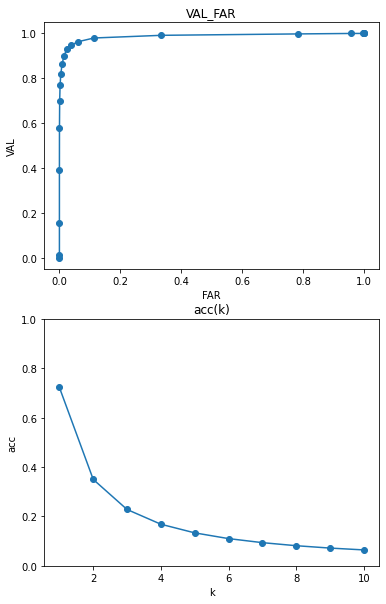

In [26]:
def showVAL_FAR_ACC(valList, farList, accList, accK):
    fig, axs = plt.subplots(2, 1, figsize=(6, 10))
    plt.title('VAL_FAR')
    
    axs[1].set_ylim([0,1])
    
    axs[0].title.set_text('VAL_FAR')
    axs[1].title.set_text('acc(k)')

    axs[0].set_xlabel('FAR')
    axs[0].set_ylabel('VAL')

    axs[1].set_xlabel('k')
    axs[1].set_ylabel('acc')

    # plt.legend(['model'], loc='center right')
    axs[0].scatter(farList, valList)
    axs[0].plot(farList, valList)
    axs[1].scatter(accK, accList)
    axs[1].plot(accK, accList)

    plt.savefig('ROC_ACC.png')
    plt.show()
showVAL_FAR_ACC(valList, farList, accList, accK)

### 沒看過的臉

In [27]:
y_pre_never, y_never = validation(never_loader, val_model)
calculateClusterDistClose_GPU(y_pre_never, y_never)

14it [00:00, 15.51it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378098133/work/aten/src/ATen/native/IndexingUtils.h:30.)
  # Remove the CWD from sys.path while we load stuff.


(array(0.7675011, dtype=float32), array(1.3631184, dtype=float32))

In [21]:
from sklearn.decomposition import PCA
def feature2pca(y_pre):
    pca = PCA(n_components=2)
    return pca.fit_transform(y_pre)
y_pre_never_pca = feature2pca(y_pre_never)

In [22]:
from sklearn import manifold
def featurn2tsne(y_pre):
    return manifold.TSNE(n_components=2, init='random', random_state=5, verbose=0).fit_transform(y_pre)

y_pre_never_tsne = featurn2tsne(y_pre_never)

In [23]:
def draw_cluster(pca_data, target):
    times = [0 for i in range(len(dataset_never.class_to_idx))]
#     plt.legend(dataset_never.class_to_idx.keys(), loc='center right')
    plt.title('cluster')
    plt.ylabel('Y')
    plt.xlabel('X')
    
    scatter = plt.scatter(pca_data[:,0], pca_data[:,1] , c=target, marker='o')#, cmap=cmap)
    plt.legend(*scatter.legend_elements(), loc=1)
    plt.show()

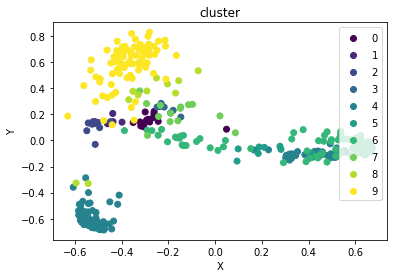

In [24]:
draw_cluster(y_pre_never_pca, y_never)

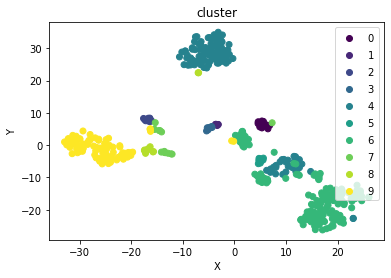

In [25]:
draw_cluster(y_pre_never_tsne, y_never)

### 一鍵測試

73it [00:04, 16.44it/s]


sameDist  0.8281499  diffDist  1.2309833


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378098133/work/aten/src/ATen/native/IndexingUtils.h:30.)
  # Remove the CWD from sys.path while we load stuff.
14it [00:01, 13.50it/s]
  0%|          | 0/21 [00:00<?, ?it/s]

sameDist_never  0.76591897  diffDist_never  1.3577337


100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


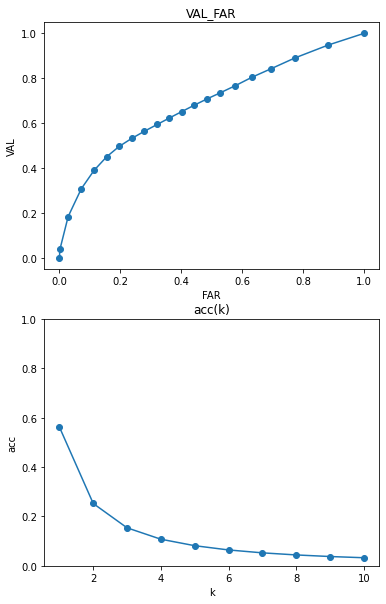

In [47]:
FAST_MODEL_PATH = "./model_simsiam_crop07/checkpoint_backbone_0100.pth.tar"
fast_model = loadEvalModel(FAST_MODEL_PATH)
y_pre, y = validation(test_loader, fast_model)
sameDist, diffDist = calculateClusterDistClose_GPU(y_pre, y)
print('sameDist ', sameDist, ' diffDist ', diffDist)
y_pre_never, y_never = validation(never_loader, fast_model)
sameDist_never, diffDist_never = calculateClusterDistClose_GPU(y_pre_never, y_never)
print('sameDist_never ', sameDist_never, ' diffDist_never ', diffDist_never)
valList, farList, accList, accK = cal(y_pre, y)
showVAL_FAR_ACC(valList, farList, accList, accK)

  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378098133/work/aten/src/ATen/native/IndexingUtils.h:30.)
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


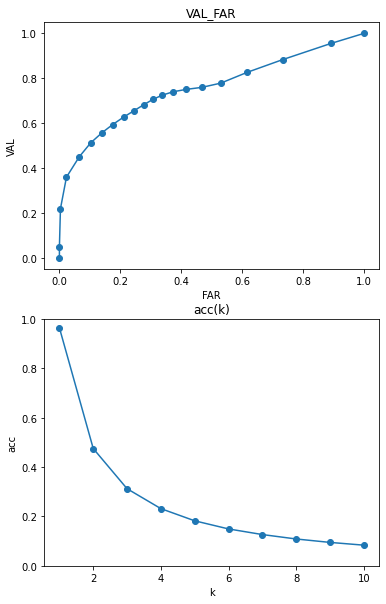

In [48]:
valList, farList, accList, accK = cal(y_pre_never, y_never)
showVAL_FAR_ACC(valList, farList, accList, accK)